In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from config import model_config
from AE.model.autoencoder import Autoencoder
from train import train
data_type = torch.float

In [2]:
model = Autoencoder(model_config)
trained_model, loss = train(model, 'data/non_diff_data.csv')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carlosmari (networkrl). Use `wandb login --relogin` to force relogin


 42%|████▏     | 83/200 [04:45<06:48,  3.49s/it]

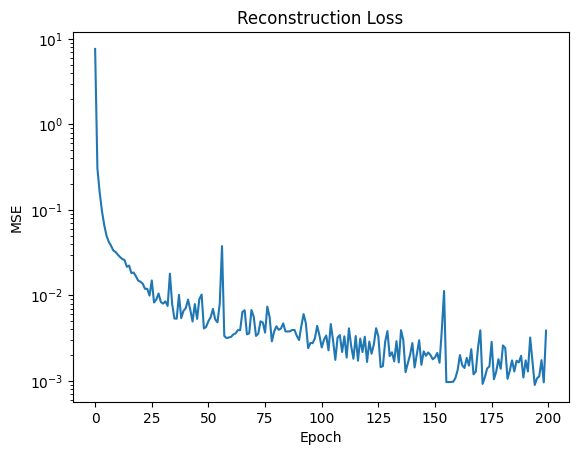

In [41]:

plt.title("Reconstruction Loss")
plt.ylabel("MSE")
plt.yscale('log')
plt.xlabel("Epoch")
plt.plot(running_losses)
plt.show()

In [42]:
# Grab the encoder and decoder
encoder = trained_model.encoder
decoder = trained_model.decoder

# Switch into evaluation mode
encoder.eval()
decoder.eval();


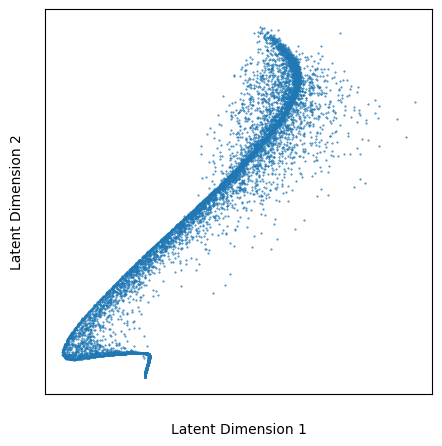

In [43]:
embeddings = encoder(X.to(device)).cpu().detach().numpy();
embeddings.shape

plt.figure(figsize = (5,5))
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left = False,
    right = False, # ticks along the top edge are off
    labelbottom=False,
    labelleft = False,
    zorder = 20) # labels along the bottom edge are off
plt.xlabel("Latent Dimension 1", labelpad= 20)
plt.ylabel("Latent Dimension 2", labelpad = 15)
plt.scatter(embeddings[:,0], embeddings[:,1], s = 0.2)
plt.show()

/var/folders/q0/lzrls2551w3btk7nl0c8dknw0000gn/T/ipykernel_33905/2529493746.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



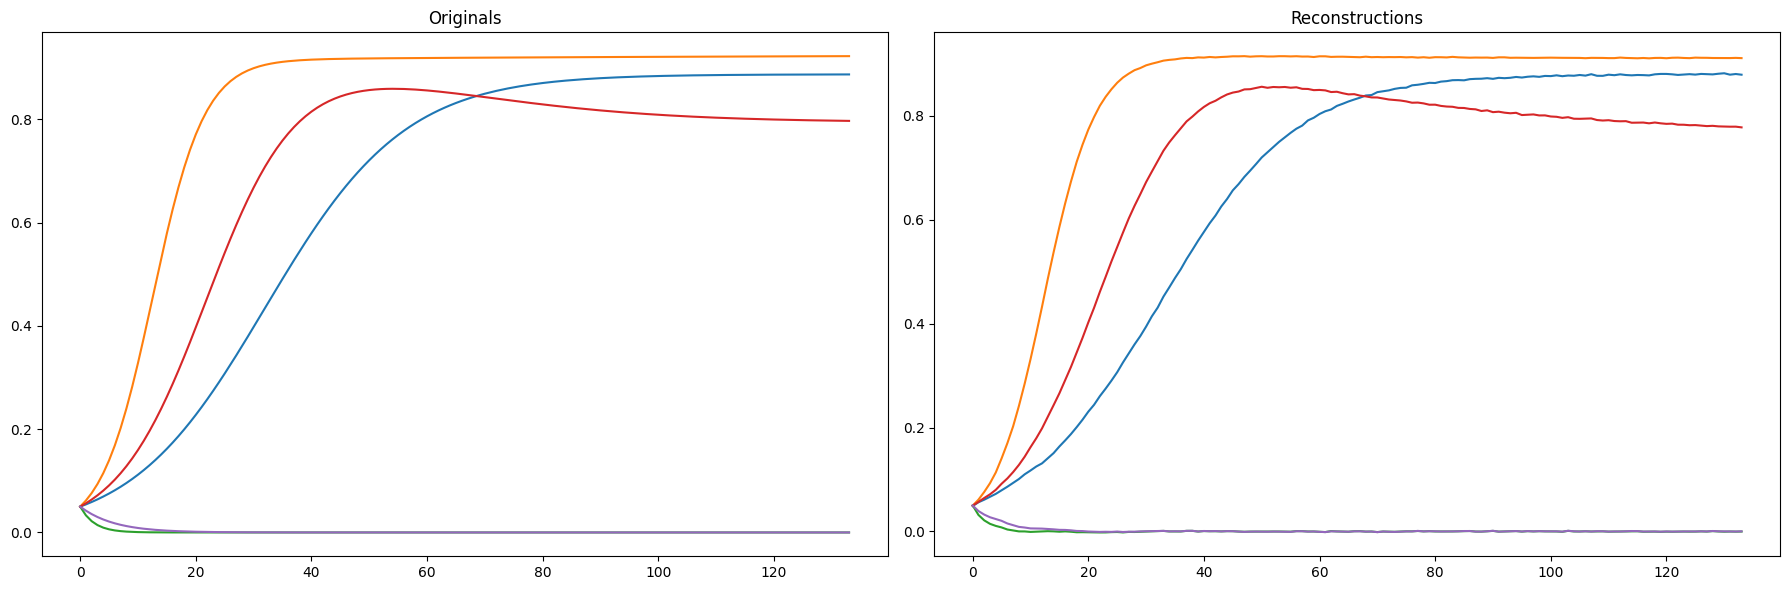

In [56]:
from matplotlib.cm import get_cmap

subset = X[np.random.randint(0,X.shape[0], size = 5), :,:].to(device)

# Generate embeddings and reconstructions
embeddings_sub = model.encoder(subset)
recons = model.decoder(embeddings_sub).cpu().detach()

# Transfer to cpu and drop gradients to enable plotting
embeddings_sub = embeddings_sub.cpu().detach()
subset = subset.cpu().detach()

fig, axs = plt.subplots(1,2, figsize = (18,6))
axs = axs.flatten()


cmap = get_cmap('tab10')  # You can change 'tab10' to any other colormap

# Plot originals
for i in range(subset.shape[0]):
    axs[0].plot(subset[i].squeeze(), color=cmap(i))
axs[0].set_title("Originals")
#axs[0].set_xlim([0, 50])

# Plot reconstructions
for i in range(recons.shape[0]):
    axs[1].plot(recons[i].squeeze(), color=cmap(i))
axs[1].set_title("Reconstructions")
#axs[1].set_xlim([0, 50])

plt.tight_layout()
plt.show()

wandb.log({"plot": wandb.Image(fig)})


In [50]:
from sklearn.decomposition import PCA

# Compute a PCA decomposition of the dataset
embeddings = encoder(X.to(device)).cpu()
pca = PCA()
X_pca = pca.fit_transform(embeddings.detach().numpy())

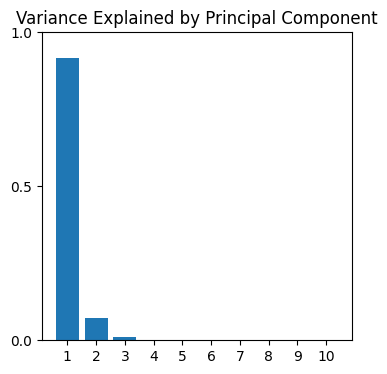

In [51]:
variances = pca.explained_variance_ratio_

# Plot formatting
plt.figure(figsize = (4,4))
plt.bar([f"{x+1}" for x in range(variances.shape[0])],height = variances)
plt.ylim(0,1.0)
plt.locator_params(axis='y', nbins=3)
plt.title("Variance Explained by Principal Component")
plt.show()

In [25]:
torch.save(model.state_dict(), './weights/fig2.pth')